In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
import string
from tqdm.notebook import tqdm

from collections import Counter
from copy import deepcopy

In [18]:
%%time

all_words = pd.read_pickle('../data/words.pkl')

CPU times: user 4.35 ms, sys: 4.82 ms, total: 9.18 ms
Wall time: 7.51 ms


In [19]:
%%time

letters = [letter for letter in string.ascii_lowercase]
positions = [f'{position}{letter}' for letter in letters for position in range(1, 6)]

CPU times: user 40 µs, sys: 2 µs, total: 42 µs
Wall time: 44.1 µs


In [20]:
def guess_word(words):    
    
    words['score'] = words['letter_score'] + words['position_score']
    
    
    if len((valid_words := words[words['is_valid']]['score'])) <= 2:
        return valid_words.index[0], valid_words[0]
    
    words['score'].where(words['is_valid'], words['score'], inplace=True)

    best_words = words['score'].sort_values(ascending=False)
        
    guess = best_words.index[0]
    score = best_words[0]
            
    return guess, score

In [21]:
def evaluate_guess(guess, solution, words, guessed_p):     
    result = ['?', '?', '?', '?', '?']

    guess_counts = Counter(guess)
    solution_counts = Counter(solution)
    green_counts = Counter()
    yellow_counts = Counter()

    # First pass
    for pos in range(5):
        letter = guess[pos]

        guessed_p[(ord(letter) - ord('a')) * 5 + pos] = 0
        
        if letter == solution[pos]:
            result[pos] = 'g'
            green_counts[letter] += 1
            
    # Second pass
    for pos in range(5):
        letter = guess[pos]
        position = f'{pos+1}{letter}'

        if result[pos] == 'g':
            words['is_valid'] *= words[position].values.astype(bool)

        elif solution_counts[letter] - (green_counts[letter] + yellow_counts[letter]) > 0:
            result[pos] = 'y'
            words['is_valid'] *= ~words[position].values.astype(bool)
            yellow_counts[letter] += 1
            
        else:
            result[pos] = 'b'
            if green_counts[letter] > 0:
                for i in range(pos, 5):
                    if not (guess[i] == letter and result[i] == 'g'):
                        words['is_valid'] *= ~words[f'{i+1}{letter}'].values.astype(bool)
            elif yellow_counts[letter] > 0:
                words['is_valid'] *= ~words[position].values.astype(bool)
            else:
                words['is_valid'] *= ~words[letter].astype(bool)
                
    # Final pass
    for letter in set(guess):
        if (letter_count := (green_counts[letter] + yellow_counts[letter])) > 0:
            words['is_valid'] *= (words[letter].values >= letter_count)
        
    return ''.join(result)

In [22]:
def adjust_score(words, words_l, words_p, guessed_p):
    
    valid_words = words[words['is_valid']]
    total_valid_words = valid_words.shape[0]
    
    valid_positions = valid_words[positions].values

    position_scores = np.sum(valid_positions * guessed_p, axis=0) / total_valid_words * 100
    
    letter_scores = position_scores.reshape((-1, 5)).sum(axis=1) / 5
    
    words['letter_score'] = np.sum(letter_scores * words_l, axis=1)
        
    words['position_score'] = np.sum(position_scores * words_p, axis=1)

In [34]:
def solve_word(solution, first_guess=None):
    words = all_words.copy()

    words_l = words[letters].astype(bool).values
    words_p = words[positions].values

    guessed_p = np.ones((len(positions),), dtype=int)
    
    for guess_num in range(1, 10):
        if guess_num == 1 and first_guess is not None:
            guess, score = (first_guess, words.loc[first_guess].score)
        else:
            guess, score = guess_word(words)
            
        result = evaluate_guess(guess, solution, words, guessed_p)
        print(guess, f'{score:.2f}', result)
        if result == 'ggggg':
            return solution, guess_num
        
        adjust_score(words, words_l, words_p, guessed_p)
            
    return solution, 100

In [38]:
%%time

solve_word('kitty')

soare 261.86 bbbbb
juicy 146.99 bbybg
dilli 201.43 bgbbb
pints 124.62 bgbgb
fetwa 130.00 bbgbb
bitty 60.00 bgggg
kitty 120.00 ggggg
CPU times: user 83.1 ms, sys: 10.6 ms, total: 93.7 ms
Wall time: 89.2 ms


('kitty', 7)

In [26]:
solutions = [solve_word(valid_word) for valid_word in tqdm(all_words[all_words['is_valid']].index)]

  0%|          | 0/2315 [00:00<?, ?it/s]

In [27]:
solutions = pd.DataFrame(solutions, columns=['word', 'guesses']).set_index('word').sort_values('guesses')

In [28]:
solutions[solutions.guesses == 100]

,guesses
word,


(array([  74.,  805., 1119.,  290.,   27.]),
 array([2, 3, 4, 5, 6, 7]),
 <BarContainer object of 5 artists>)

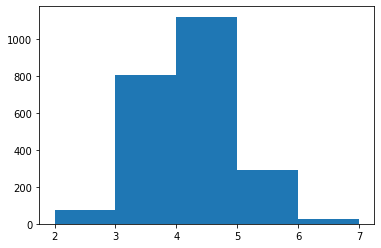

In [29]:
plt.hist(solutions.guesses, bins=[2, 3, 4, 5, 6, 7])